

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>




## Polynomial Regression with Shrinkage Term

#### Danielle Marques Raposo Cotia
#### PGE, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


### Executive Summary

Polynomial regression is used to build models to fit non-linear data, it consists in using linear regression over the values of the predictive(s) feature(s) power expansion. However the degree of the polynomial expansion to fit the data is not an obvious choice. This workflow aims to address this problem by using LASSO regression, instead of linear regression, over a higher degree orthogonal polynomial expansion in order to verify if the feature selection capability of the method will help to choose the degree of the polynomial that best fits the data. 
Using a sintethic data set of third degree polynomial with noise it was possible to find a better solution with LASSO regression of the eigth degree polynomial expansion that had a smaller MSE than the linear regression for the same basis expansion.
It is recommended that when trying to fit a polynomial regression to a dataset, LASSO regression is tried as a step to give some indication of the degree of the polynomial basis expansion to be used.

### Import Packages

In [362]:
%matplotlib inline                                         
suppress_warnings = True
import os                                                     # to set current working directory 
import math                                                   # square root operator
import numpy as np                                            # arrays and matrix math
from scipy import stats                                       # statistical methods
import pandas as pd                                           # DataFrames
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter) # control of axes ticks
from sklearn.linear_model import LinearRegression             # linear regression with scikit learn
from sklearn.preprocessing import PolynomialFeatures          # polynomial basis expansion
from sklearn import metrics                                   # measures to check our models
from sklearn.preprocessing import (StandardScaler,PolynomialFeatures) # standardize the features, polynomial basis expansion
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV,KFold) # model tuning
from sklearn.pipeline import (Pipeline,make_pipeline)         # machine learning modeling pipeline
from sklearn import metrics                                   # measures to check our models
from sklearn.model_selection import cross_val_score           # multi-processor K-fold crossvalidation
from sklearn import linear_model                              # linear regression
from sklearn.linear_model import Lasso                        # LASSO regression implemented in scikit-learn
from sklearn.model_selection import train_test_split          # train and test split
import geostatspy.geostats as geostats                        # for Gaussian transform from GSLIB
from sklearn.metrics import mean_squared_error                # calculate MSE to compare models
if suppress_warnings == True:  
    import warnings                                           # supress any warnings for this demonstration
    warnings.filterwarnings('ignore') 

### Functions

The following functions will be used in the workflow. Functions from professor Michael Pyrcz's e-book (https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_LASSO_regression.html)

In [316]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
    
# Functions below were referenced in Polynomial regression chapter of Dr Michael Pyrcz's e-book
# https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_polynomial_regression.html
# functions were originally taken from http://davmre.github.io/blog/python/2013/12/15/orthogonal_poly

def ortho_poly_fit(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

def ortho_poly_predict(x, alpha, norm2, degree = 1):
    x = np.asarray(x).flatten()
    n = degree + 1
    Z = np.empty((len(x), n))
    Z[:,0] = 1
    if degree > 0:
        Z[:, 1] = x - alpha[0]
    if degree > 1:
        for i in np.arange(1,degree):
             Z[:, i+1] = (x - alpha[i]) * Z[:, i] - (norm2[i] / norm2[i-1]) * Z[:, i-1]
    Z /= np.sqrt(norm2)
    return Z

### Load Data

The following workflow applies the .csv file 'pol-degree3-noisy-norm.csv', a synthetic dataset created for this workflow that is a 3rd degree polynomial curve with random numbers add to the response feature to account for noise. The dataset is already normalied and consists of 40 samples and will be visualized inside the workflow steps for conciseness.

In [365]:
df = pd.read_csv(r"https://raw.githubusercontent.com/dcotia/MLdataset/refs/heads/main/DataSet_Danielle_Cotia.csv")

Specify lables and limits for visualization:

In [368]:
Xname = ['X']; yname = ['Y']                                # select the predictor and response feature

Xlabel = ['Normalized X']; ylabel = ['Normalized Y']        # specify the feature labels for plotting
Xunit = ['m']; yunit = ['m']
Xlabelunit = [Xlabel[0] + ' (' + Xunit[0] + ')']
ylabelunit = ylabel[0] + ' (' + yunit[0] + ')'

Xmin = 0; Xmax = 1.0                                       # limits for plotting
ymin = 0; ymax = 1.0

X_values = np.linspace(Xmin,Xmax,100)                      # X intervals to visualize the model 

### Polynomial regression using LASSO

The dataset will be split into training and test so that the MSE (mean squared error) for the testing data can be used to compare models. Then a model will be fit with a higher degree polynomial basis expansion with both linear and LASSO regression. We want to check if there is a value for $\lambda$ hyperparameter that gives a smaller MSE than linear regression and plot the coefficients values for lasso regression over the lambdas to see which coefficients (related to each power of the expanded basis) can be dropped.



#### 1. Train/Test Split

We use 25% of the data for testing and 75% for training. It means that, from the 40 datapoint we have in this dataset, 10 points will be withheld and not used for training the model. This is important so that we can have a metrics to compare different models.

In [372]:
x_train, x_test, y_train, y_test = train_test_split(df[Xname],df[yname],test_size=0.25,random_state=73073) # train and test split
df_train = pd.concat([x_train,y_train],axis=1)                # features as train and test DataFrames
df_test = pd.concat([x_test,y_test],axis=1)

#### 2. Build linear regression model

We will visualize the testing and training data and fit it to a linear regression model, so that we calculate the MSE for this model and compare it with the polynomial model we intend to fit. Here we do not use the basis expansion, just X as predictive feature. These code blocks were modified from Dr. Michael Pyrcz e-book on Machine Learning (https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_polynomial_regression.html)

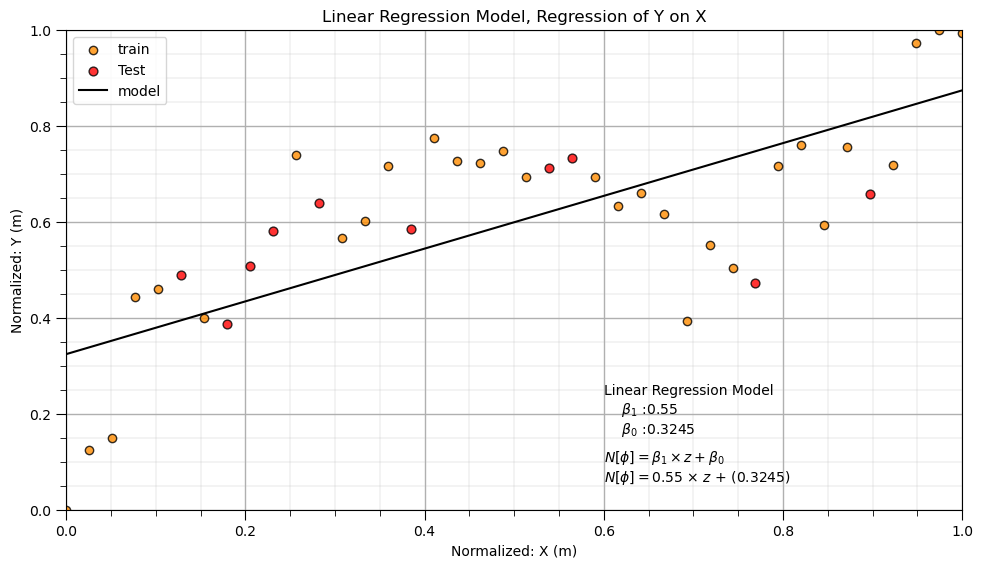

In [375]:
lin_ns_train = LinearRegression()                                   # instantiate linear regression object, note no hyperparameters 
lin_ns_train.fit(x_train, y_train)                                  # train linear regression model
slope_ns = lin_ns_train.coef_[0]                                    # get the model parameters
intercept_ns = lin_ns_train.intercept_

plt.subplot(111)                                                    # plot the data and the model
plt.scatter(x_train,y_train,marker='o',label='train',color = 'darkorange',alpha = 0.8,edgecolor = 'black')
plt.scatter(df_test[Xname],df_test[yname],s=40,marker='o',color = 'red',alpha = 0.8,edgecolor = 'black',zorder=10,label='Test')
plt.plot(X_values,intercept_ns + slope_ns*X_values,label='model',color = 'black')
plt.title('Linear Regression Model, Regression of ' + yname[0] + ' on ' + Xname[0])
plt.xlabel('Normalized: ' + Xname[0] + ' (' + Xunit[0] + ')')
plt.ylabel('Normalized: ' + yname[0] + ' (' + yunit[0] + ')')
plt.legend(); add_grid(); plt.xlim([0,1.0]); plt.ylim([ymin,ymax])
plt.annotate('Linear Regression Model',[0.6,.24])
plt.annotate(r'    $\beta_1$ :' + str(round(slope_ns[0],2)),[.6,.2])
plt.annotate(r'    $\beta_0$ :' + str(round(intercept_ns[0],4)),[.6,.16])
plt.annotate(r'$N[\phi] = \beta_1 \times z + \beta_0$',[0.6,.1])
plt.annotate(r'$N[\phi] = $' + str(round(slope_ns[0],2)) + r' $\times$ $z$ + (' + str(round(intercept_ns[0],4)) + ')',[0.6,.06])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.4, top=1, wspace=0.2, hspace=0.2); plt.show()

Calculate MSE for the linear regression model with no basis expansion:

In [378]:
MSE_lin_reg = mean_squared_error(y_test, lin_ns_train.predict(x_test), sample_weight=None, multioutput='uniform_average')
print('Test MSE for linear regression model:', MSE_lin_reg)

Test MSE for linear regression model: 0.017877475780530533


### 3. Build Polynomial Regression model with linear regression

Now we will expand X in 8 powers and use this new set of predictive features to fit a linear model, using our training data, and compare the MSE with that for the multilinear regression model. The choice for 8 degree polynomial was arbitrary, but considered a high order polynomial considering the concise dataset (only 40 samples, 30 for training). We decided to use an orthogonal polynomial basis expansion in order to avoid multicolinearity.

First we create the basis expansion, for both train and test datasets:

In [380]:
#train
X_ns_ortho8_train, norm2, alpha = ortho_poly_fit(x_train.values.reshape(-1, 1), degree = 8) # orthogonal polynomial expansion
df_X_ns_ortho8_train = pd.DataFrame({'value':x_train.iloc[:,0],'1st':X_ns_ortho8_train[:,1],'2nd':X_ns_ortho8_train[:,2],'3rd':X_ns_ortho8_train[:,3],
                               '4th':X_ns_ortho8_train[:,4], '5th':X_ns_ortho8_train[:,5], '6th':X_ns_ortho8_train[:,6], '7th':X_ns_ortho8_train[:,7],
                              '8th':X_ns_ortho8_train[:,8]})       # make a new DataFrame from the vectors
#test
X_ns_ortho8_test, norm2, alpha = ortho_poly_fit(x_test.values.reshape(-1, 1), degree = 8) # orthogonal polynomial expansion
df_X_ns_ortho8_test = pd.DataFrame({'value':x_test.iloc[:,0],'1st':X_ns_ortho8_test[:,1],'2nd':X_ns_ortho8_test[:,2],'3rd':X_ns_ortho8_test[:,3],
                               '4th':X_ns_ortho8_test[:,4], '5th':X_ns_ortho8_test[:,5], '6th':X_ns_ortho8_test[:,6], '7th':X_ns_ortho8_test[:,7],
                              '8th':X_ns_ortho8_test[:,8]})       # make a new DataFrame from the vectors
#df_X_ns_ortho8_train.head() #we will not visualize for conciseness

Now we use it to build a multi-linear regression model (it works as if each power transforms into a new feature describing the response feature):

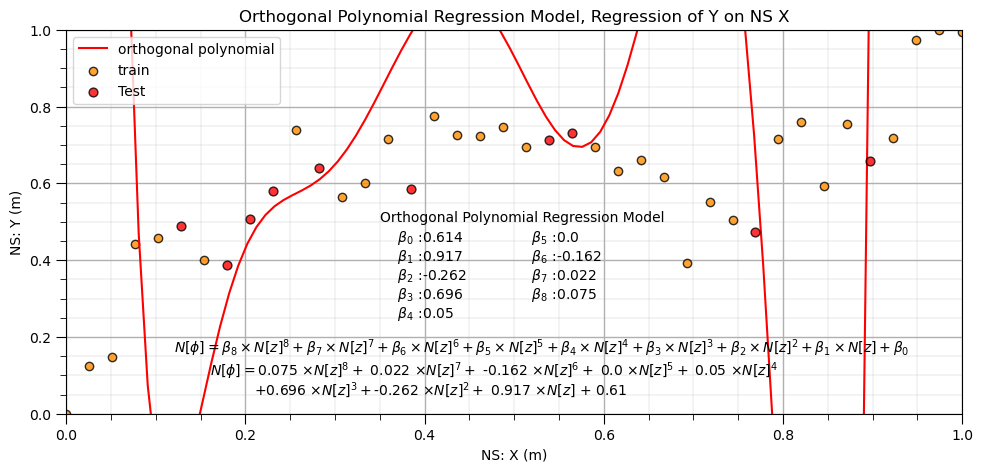

In [383]:
#modified from (https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_polynomial_regression.html)
#create orthogonal basis values for plotting continuos function
ortho_poly_ns_values = ortho_poly_predict(X_values.reshape(-1, 1), alpha, norm2, degree = 8)

lin_ortho8 = LinearRegression()                                               # instantiate model
lin_ortho8.fit(df_X_ns_ortho8_train.iloc[:,1:], y_train.iloc[:,0])            # fit orthogonal polynomials 
ob1,ob2,ob3,ob4,ob5,ob6,ob7,ob8 = np.round(lin_ortho8.coef_,3)                # retrieve the model parameters
ob0 = lin_ortho8.intercept_

plt.subplot(111)
plt.plot(X_values,lin_ortho8.predict(ortho_poly_ns_values[:,1:]),label='orthogonal polynomial',color = 'red') 
plt.scatter(x_train,y_train,marker='o',label='train',color = 'darkorange',alpha = 0.8,edgecolor = 'black')
plt.scatter(df_test[Xname],df_test[yname],s=40,marker='o',color = 'red',alpha = 0.8,edgecolor = 'black',zorder=10,label='Test')
plt.title('Orthogonal Polynomial Regression Model, Regression of ' + yname[0] + ' on NS ' + Xname[0])
plt.xlabel('NS: ' + Xname[0] + ' (' + Xunit[0] + ')')
plt.ylabel('NS: ' + yname[0] + ' (' + yunit[0] + ')')
plt.legend(); add_grid(); plt.xlim([0.0,1.0]); plt.ylim([0,1])
plt.annotate('Orthogonal Polynomial Regression Model',[0.35,.5])
plt.annotate(r'    $\beta_8$ :' + str(round(ob8,3)),[.5,.3])
plt.annotate(r'    $\beta_7$ :' + str(round(ob7,3)),[.5,0.35])
plt.annotate(r'    $\beta_6$ :' + str(round(ob6,3)),[.5,0.4])
plt.annotate(r'    $\beta_5$ :' + str(round(ob5,3)),[.5,0.45])
plt.annotate(r'    $\beta_0$ :' + str(round(ob0,3)),[.35,.45])
plt.annotate(r'    $\beta_1$ :' + str(round(ob1,3)),[.35,.4])
plt.annotate(r'    $\beta_2$ :' + str(round(ob2,3)),[.35,.35])
plt.annotate(r'    $\beta_3$ :' + str(round(ob3,3)),[.35,.3])
plt.annotate(r'    $\beta_4$ :' + str(round(ob4,2)),[.35,0.25])
plt.annotate(r'$N[\phi] = \beta_8 \times N[z]^8 + \beta_7 \times N[z]^7 + \beta_6 \times N[z]^6 + \beta_5 \times N[z]^5 + \beta_4 \times N[z]^4 + \beta_3 \times N[z]^3 + \beta_2 \times N[z]^2 + \beta_1 \times N[z] + \beta_0$',[.12,.16])
plt.annotate(r'$N[\phi] = $' + str(ob8) + r' $\times N[z]^8 +$ ' + str(ob7) + r' $\times N[z]^7 +$ ' + str(ob6) + 
             r' $\times N[z]^6 +$ ' + str(ob5) + r' $\times N[z]^5 +$ ' + 
             str(ob4) + r' $\times N[z]^4$',[.16,.1])
plt.annotate(r'          $+$'+str(ob3) + r' $\times N[z]^3 +$' + str(ob2) + r' $\times N[z]^2 +$ ' + 
             str(ob1) + r' $\times N[z]$ + ' + str(round(ob0,2)),[.16,.05])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.4, top=0.8, wspace=0.2, hspace=0.2); plt.show()

Calculate test MSE for the eigth degree polynomial regression:

In [386]:
MSE_lin_reg_ortho8 = mean_squared_error(y_test, lin_ortho8.predict(X_ns_ortho8_test[:,1:]), sample_weight=None, multioutput='uniform_average')
print('Test MSE for polynomial regression model:', MSE_lin_reg_ortho8)
print('What is ', round(MSE_lin_reg_ortho8/MSE_lin_reg, 1), ' times the MSE that was obtained by standard linear regression without polynomial basis expansion.')

Test MSE for polynomial regression model: 0.11016400487125588
What is  6.2  times the MSE that was obtained by standard linear regression without polynomial basis expansion.


### 4. Apply LASSO regression for feature selection and atempt for a better fit


We assume the polynomial has a very high degree what leads the model to fit noise so we will try LASSO regression over the same 8th-degree orthogonal polynomial basis expansion and visualize the feature selection over the power of X. Next pieces of code were modified from LASSO regression chapter of Dr. Michael Pyrcz Machine Learning e-book (https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_LASSO_regression.html).

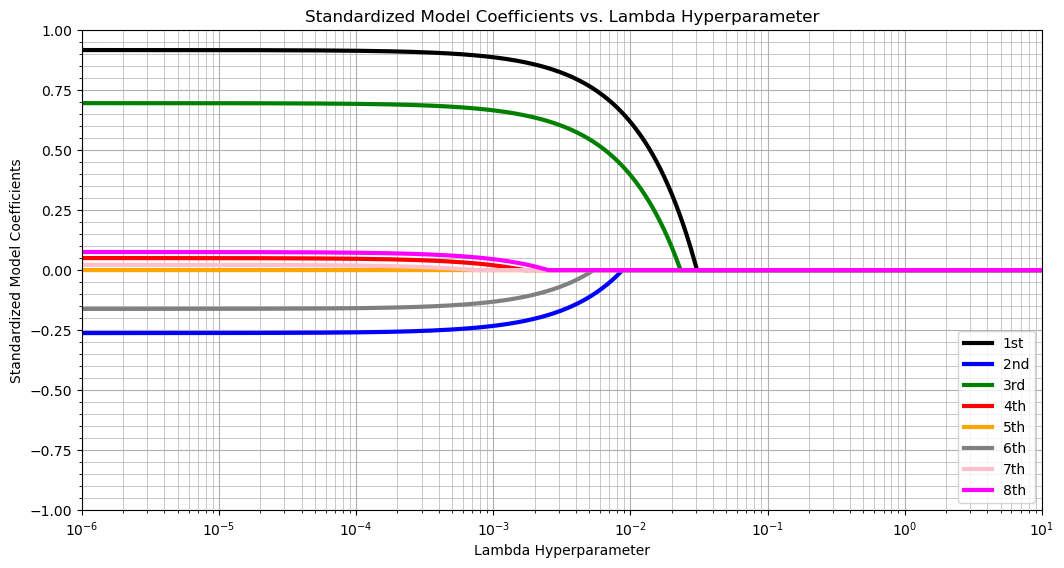

In [390]:
nbins = 1000                                                # number of bins to explore the hyperparameter 
df_X_ns_ortho8_train.iloc[:,1:].describe().transpose()       # summary statistics from the new DataFrame                        
lams = np.logspace(-6,1,nbins)                              # make a list of lambda values
coefs = np.ndarray((nbins,8))

index = 0
for lam in lams:
    lasso_reg = Lasso(alpha=lam)                            # instantiate the model
    lasso_reg.fit(X_ns_ortho8_train[:,1:], y_train)                         # fit model
    coefs[index,:] = lasso_reg.coef_                        # retrieve the coefficients
    index = index + 1
    
color = ['black','blue','green','red','orange','grey','pink','magenta']
plt.subplot(111)                                            # plot the results
for ifeature in range(0,8):
    plt.semilogx(lams,coefs[:,ifeature], label = df_X_ns_ortho8_train.iloc[:,1:].columns[ifeature], c = color[ifeature], linewidth = 3.0)

plt.title('Standardized Model Coefficients vs. Lambda Hyperparameter'); plt.xlabel('Lambda Hyperparameter'); plt.ylabel('Standardized Model Coefficients')
plt.xlim(1.0e-6,1.0e1); plt.ylim(-1.0,1.0); plt.grid(); plt.legend(loc = 'lower right')
plt.grid(True); plt.minorticks_on(); plt.grid(which='minor', linewidth=0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1., wspace=0.2, hspace=0.2); plt.show()

In this graph, tested over multiple lambda parameter (the hyperparameter for LASSO regression), the coefficients of the orders that aproximate to zero for the smaller lambdas are the first to be dropped, i.e., they probably don't contribute for the fitting. From the graph we notice that the last coefficients to be dropped are the 1st and 3rd order, what agrees with the fact that our data was a 3rd order polynomial (with noise). We still need to know if for any of these $\lambda$'s gave us a better fitting than linear regression of the polynomial basis expansion, and we still need to compare it with the simple linear regression over X.

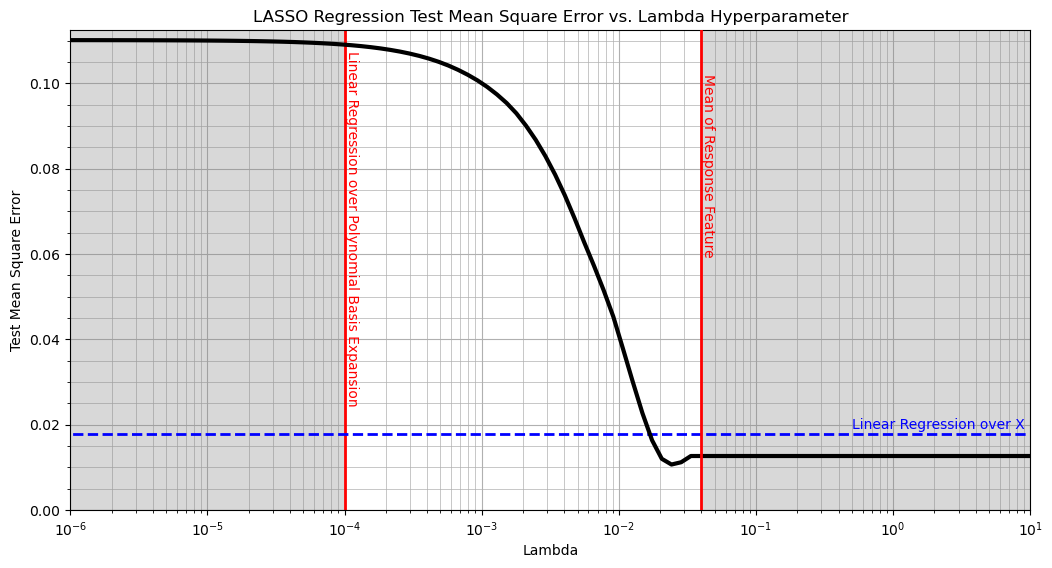

In [392]:
#modified from (https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_LASSO_regression.html)
score = np.linspace(Xmin,Xmax,100)                                                   # code modified from StackOverFlow by Dimosthenis

nlambda = 100
lambda_min = 0
score_min = 100
lambda_mat = np.logspace(-6,1,nlambda)
for ilam in range(0,nlambda):
    lasso_reg = Lasso(alpha=lambda_mat[ilam])
    lasso_reg.fit(X_ns_ortho8_train[:,1:], y_train) 
    score[ilam] = mean_squared_error(y_test, lasso_reg.predict(X_ns_ortho8_test[:,1:]), sample_weight=None, multioutput='uniform_average')


plt.subplot(111)
plt.plot(lambda_mat, score,  color='black', linewidth = 3, label = 'Test MSA',zorder=10)
plt.title('LASSO Regression Test Mean Square Error vs. Lambda Hyperparameter'); plt.xlabel('Lambda'); plt.ylabel('Test Mean Square Error')
plt.xlim(1.0e-6,1.0e1);plt.ylim(0,1.1250e-1); plt.xscale('log')
plt.vlines(1.0e-4,0,20,color='red',lw=2); plt.vlines(0.04,0,20,color='red',lw=2,zorder=10)
plt.hlines(MSE_lin_reg,1.0e-8,1.0e2,color='blue',lw=2, ls = 'dashed')
plt.annotate('Linear Regression over X',[0.5,0.019],color='blue',zorder=10)
plt.annotate('Linear Regression over Polynomial Basis Expansion',[1.0e-4,0.025],rotation=-90.0,color='red',zorder=10)
plt.annotate('Mean of Response Feature',[0.04,0.06],rotation=-90.0,color='red',zorder=10)
plt.fill_between([1.0e-8,1.0e-4],[0,0],[20,20],color='grey',alpha=0.3,zorder=1)
plt.fill_between([0.04,100000],[0,0],[20,20],color='grey',alpha=0.3,zorder=1)
plt.grid(which='both');# add_grid()
plt.grid(True); plt.minorticks_on(); plt.grid(which='minor', linewidth=0.5)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.2, hspace=0.2); plt.show()

We do have a value of lambda of that minimizes the MSE over the test data, making a better prediction model than simple linear regression over and basic polynomial regression (multilinear regression over polynomial basis expansion).

Now, we will visualize the model obtained with LASSO regression over the polynomial basis expansion, we will use a value for lambda in the range of 0.02, where we have smaller MSE and the 3rd degree polynomial. Note that the coefficients for the higher order vanished.

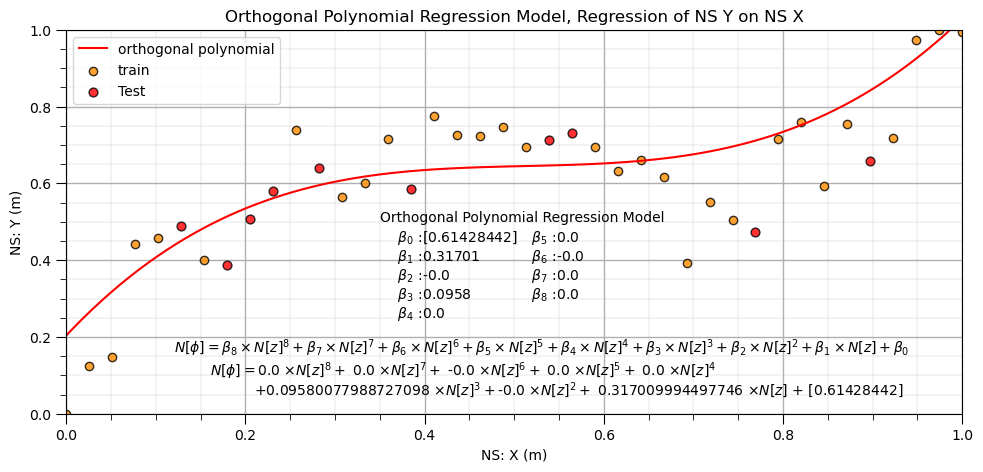

In [397]:
lam = 0.02                                                  # lambda hyperparameter

lasso_reg = Lasso(alpha=lam)                                  # instantiate the model

lasso_reg.fit(X_ns_ortho8_train[:,1:], y_train) # train the model parameters

plt.subplot(111)
plt.plot(X_values,lasso_reg.predict(ortho_poly_ns_values[:,1:]),label='orthogonal polynomial',color = 'red') 
plt.scatter(x_train,y_train,marker='o',label='train',color = 'darkorange',alpha = 0.8,edgecolor = 'black')
plt.scatter(df_test[Xname],df_test[yname],s=40,marker='o',color = 'red',alpha = 0.8,edgecolor = 'black',zorder=10,label='Test')
plt.title('Orthogonal Polynomial Regression Model, Regression of NS ' + yname[0] + ' on NS ' + Xname[0])
plt.xlabel('NS: ' + Xname[0] + ' (' + Xunit[0] + ')')
plt.ylabel('NS: ' + yname[0] + ' (' + yunit[0] + ')')
plt.legend(); add_grid(); plt.xlim([0.0,1.0]); plt.ylim([ymin,ymax])
plt.annotate('Orthogonal Polynomial Regression Model',[0.35,.5])
plt.annotate(r'    $\beta_8$ :' + str(round(lasso_reg.coef_ [7],3)),[.5,.3])
plt.annotate(r'    $\beta_7$ :' + str(round(lasso_reg.coef_ [6],3)),[.5,0.35])
plt.annotate(r'    $\beta_6$ :' + str(round(lasso_reg.coef_ [5],3)),[.5,0.4])
plt.annotate(r'    $\beta_5$ :' + str(round(lasso_reg.coef_ [4],3)),[.5,0.45])
plt.annotate(r'    $\beta_0$ :' + str(lasso_reg.intercept_),[.35,.45])
plt.annotate(r'    $\beta_1$ :' + str(round(lasso_reg.coef_ [0],5)),[.35,.4])
plt.annotate(r'    $\beta_2$ :' + str(round(lasso_reg.coef_ [1],5)),[.35,.35])
plt.annotate(r'    $\beta_3$ :' + str(round(lasso_reg.coef_ [2],5)),[.35,.3])
plt.annotate(r'    $\beta_4$ :' + str(round(lasso_reg.coef_ [3],2)),[.35,0.25])
plt.annotate(r'$N[\phi] = \beta_8 \times N[z]^8 + \beta_7 \times N[z]^7 + \beta_6 \times N[z]^6 + \beta_5 \times N[z]^5 + \beta_4 \times N[z]^4 + \beta_3 \times N[z]^3 + \beta_2 \times N[z]^2 + \beta_1 \times N[z] + \beta_0$',[.12,.16])
plt.annotate(r'$N[\phi] = $' + str(lasso_reg.coef_ [7]) + r' $\times N[z]^8 +$ ' + str(lasso_reg.coef_ [6]) + r' $\times N[z]^7 +$ ' + str(lasso_reg.coef_ [5]) + 
             r' $\times N[z]^6 +$ ' + str(lasso_reg.coef_ [4]) + r' $\times N[z]^5 +$ ' + 
             str(lasso_reg.coef_ [3]) + r' $\times N[z]^4$',[.16,.1])
plt.annotate(r'          $+$'+str(lasso_reg.coef_ [2]) + r' $\times N[z]^3 +$' + str(lasso_reg.coef_ [1]) + r' $\times N[z]^2 +$ ' + 
             str(lasso_reg.coef_ [0]) + r' $\times N[z]$ + ' + str(lasso_reg.intercept_),[.16,.05])

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.4, top=0.8, wspace=0.2, hspace=0.2); plt.show()

In [356]:
MSE_lin_reg_lasso = mean_squared_error(y_test, lasso_reg.predict(X_ns_ortho8_test[:,1:]), sample_weight=None, multioutput='uniform_average')
print('Test MSE for polynomial regression model:', round(MSE_lin_reg_lasso,4), ' is ', round(MSE_lin_reg_lasso/MSE_lin_reg,2), 'times smaller than that for linear regression.')

Test MSE for polynomial regression model: 0.0127  is  0.71 times smaller than that for linear regression.


### Summary and conclusions

The workflow proposed was executed and suceeded in finding a LASSO regression of the orthogonal polynomial basis expansion of the predictive feature that performed better to reduce the MSE of test data than the multilinear regression of the same polynomial basis expansion, which is the common approach for polynomial regression, and the simple linear regression using only the original normalized values of the predictive feature.
Not only this result is interesting, but also the ability of LASSO regression to feature select helps in selecting the degree of the polynomial that could be used, making it possible to suppress the higher order terms.
We consider it would be a good approach to use LASSO instead of linear regression over the polynomial basis expansion when performing polynomial regression.

#### About the Author

Danielle Cotia is a senior reservoir engineer at Petrobras and is currently sponsored by the company to pursue her PhD degree in Petroleum Engineering at University of Texas at Austin.